In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['fruits-360_dataset']


In [2]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from glob import glob

In [3]:
train_dir = '../input/fruits-360_dataset/fruits-360/Training'
test_dir = '../input/fruits-360_dataset/fruits-360/Test'

In [4]:
#Check how many images in training file
train_images = glob(os.path.join(train_dir,'*/*.jpg'))
num_images = len(train_images)
print('Number of images in training files:', num_images)

Number of images in training files: 57276


In [5]:
num_images = 57276
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count')
print('-' * 24)
for folder in os.listdir(os.path.join(train_dir)):
    folder_num = len(os.listdir(os.path.join(train_dir, folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < num_images):
        num_images = folder_num
        folder_name = folder
        
num_classes = len(class_names)
print("\nThe least images:", num_images, ' Category:', folder)
print('Total number of classes: {}'.format(num_classes))

class             Count
------------------------
Nectarine            492
Kaki                 490
Pear Red             666
Avocado              427
Redcurrant           492
Onion Red            450
Apple Golden 3       481
Apple Pink Lady      456
Potato White         450
Lemon                492
Kohlrabi             471
Pepper Yellow        666
Pear Monster         490
Tomato 1             738
Cherry 2             738
Grape White 4        471
Apple Red 1          492
Pear Abate           490
Mandarine            490
Pear Kaiser          300
Strawberry           492
Cherry Rainier       738
Plum 3               900
Cocos                490
Cantaloupe 2         492
Peach 2              738
Banana Lady Finger   450
Nut Forest           218
Pepper Green         444
Granadilla           490
Apple Red Yellow 2   672
Apple Crimson Snow   444
Pomegranate          492
Lychee               490
Quince               490
Hazelnut             464
Raspberry            490
Tangelo              490
M

In [6]:
# Define transforms for the training and validation sets
data_transforms ={
    "train_transforms": transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor()]),
   "valid_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor()]), 
    "test_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor()])
}

In [7]:
# Split the dataset into train and validation
train_data = 0.8
valid_data = 0.2

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=data_transforms["train_transforms"])
valid_data = datasets.ImageFolder(train_dir, transform=data_transforms["valid_transforms"])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms["test_transforms"])

# Obtain training indices that will be used for validation and test
num_train = len(train_data)
indices = list(range(num_train))
train_count = int(0.8*num_train)
valid_count = num_train - train_count
test_count = len(test_data)
train_idx = indices[:train_count]
valid_idx = indices[train_count:]
print(len(train_idx), len(valid_idx), test_count)
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count)

45820 11456 19548
Training 45820 0.7999860325441721
Validation 11456 0.20001396745582792
Test 19548


In [8]:
# Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
# Define the dataloaders using the image datasets
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = True)

In [10]:
#helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert tensor image

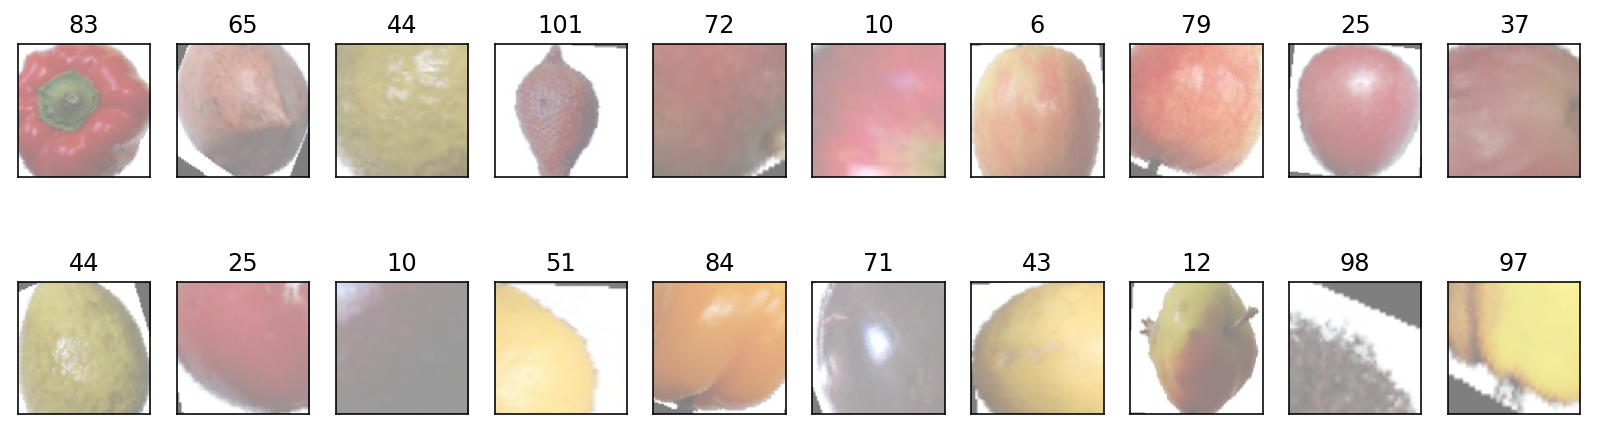

In [11]:
#Visualize some sample data
#Obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() #convert images to numpy for display

#Plot the images in the batch, along with corresponding labels
fig = plt.figure(figsize=(14,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(str(labels[idx].item()))

In [12]:
# Specify model architecture
# Load the pretrained model from pytorch
model_transfer = models.densenet201(pretrained=True)

# Check if GPU is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /tmp/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 81131730/81131730 [00:01<00:00, 75941604.38it/s]


In [13]:
# Freeze training for all 'features' layers
for param in model_transfer.features.parameters():
    param.requires_grad=False

In [14]:
# Total image label
n_inputs = model_transfer.classifier.in_features

# Add last linear layer (n_inputs -> 114 classes)
# New layer automatically has requires_grad = True
last_layer = nn.Linear(n_inputs, num_classes) 

model_transfer.classifier = last_layer

# If GPU is available, move the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()
  
# Check to see the last layer produces the expected number of outputs
print(model_transfer.classifier.out_features)

114


In [15]:
# Specify loss function and optimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01, momentum = 0.9)

In [16]:
# Train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns trained model'''
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf
  
    for epoch in range(1, n_epochs+1):
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
    
        # Model training
        model.train()
        for batch_idx, (data,target) in enumerate(trainloader):
            # Move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()
      
            # Clear the gradient of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()
            # Record the average training loss
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))
      
        # Model validation
        model.eval()
        for batch_idx, (data,target) in enumerate(validloader):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))
      
        # print training/validation stats
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss))
                # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss
  
    # Return trained model
    return model

# Define loaders transfer
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}

# Train the model
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.08314 	Validation Loss: 0.21574
Validation loss decreased (inf --> 0.21574). Saving model ...
Epoch: 2 	Training Loss: 0.41870 	Validation Loss: 0.12757
Validation loss decreased (0.21574 --> 0.12757). Saving model ...
Epoch: 3 	Training Loss: 0.32860 	Validation Loss: 0.09778
Validation loss decreased (0.12757 --> 0.09778). Saving model ...
Epoch: 4 	Training Loss: 0.27897 	Validation Loss: 0.07590
Validation loss decreased (0.09778 --> 0.07590). Saving model ...
Epoch: 5 	Training Loss: 0.25610 	Validation Loss: 0.07406
Validation loss decreased (0.07590 --> 0.07406). Saving model ...
Epoch: 6 	Training Loss: 0.23709 	Validation Loss: 0.05793
Validation loss decreased (0.07406 --> 0.05793). Saving model ...
Epoch: 7 	Training Loss: 0.22005 	Validation Loss: 0.05034
Validation loss decreased (0.05793 --> 0.05034). Saving model ...
Epoch: 8 	Training Loss: 0.21007 	Validation Loss: 0.06038
Epoch: 9 	Training Loss: 0.19771 	Validation Loss: 0.06166
Epoch: 10 	

In [ ]:
# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [17]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.101662


Test Accuracy: 97% (19109/19548)
